In [1]:
from model import *
from sortedlist import *
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
sns.set()

In [13]:
L = 1000
test = SortedList.fromlist(np.random.randint(0, 2*L, size=L) + np.random.randint(0, 2*L, size=L))
test[:25]

[96,
 126,
 138,
 167,
 178,
 184,
 202,
 245,
 253,
 257,
 264,
 283,
 322,
 339,
 348,
 353,
 368,
 369,
 373,
 379,
 384,
 385,
 387,
 392,
 416]

In [14]:
tests = enumerate(test)
testy, testx = zip(*tests)
testx = np.array(list(testx), dtype=np.float64).reshape(-1,1,1)
testy = np.array(list(testy), dtype=np.float64).reshape(-1,1,1)
dataset = tf.data.Dataset.from_tensor_slices((testx, testy))
dataset = dataset.shuffle(L)
dataset, len(dataset)

(<ShuffleDataset shapes: ((1, 1), (1, 1)), types: (tf.float64, tf.float64)>,
 1000)

Epoch 1/5
1000/1000 [==============================] - 2s 2ms/step - loss: 80802.4609 - max_absolute_error: 2319.6167
Epoch 2/5
1000/1000 [==============================] - 2s 2ms/step - loss: 7834.7129 - max_absolute_error: 156.0800
Epoch 3/5
1000/1000 [==============================] - 2s 2ms/step - loss: 7760.2607 - max_absolute_error: 155.7020
Epoch 4/5
1000/1000 [==============================] - 2s 2ms/step - loss: 7666.4336 - max_absolute_error: 159.6716
Epoch 5/5
1000/1000 [==============================] - 2s 2ms/step - loss: 7604.5234 - max_absolute_error: 172.5729
pred = [ 3  5  3  8  0  3  1  4  3  4  6  7  9  7  4  4  4  1  9  1  2  4  9  5
  2  1  3  0  4  4  3  6  5  2  4  2  4  7  9  1  3  7  6  3  7  6  4  8
  3  4  2  5  5  3  3  8  4  5  5  2  7  3  5  6  9  6  4  6  3  5  3  6
  4  9  6  4  2  4  5  9  2 10  5  3  4  2  3  1  4  3  7  3  3  4  2  8
  4  9  7  7  5  7  2  2  5  4  3  4  4  4  8  6  5  3  5  4  3  8  9  6
  7  4  6  9  4  3  4  3  5  0  5  4  2  4  1 

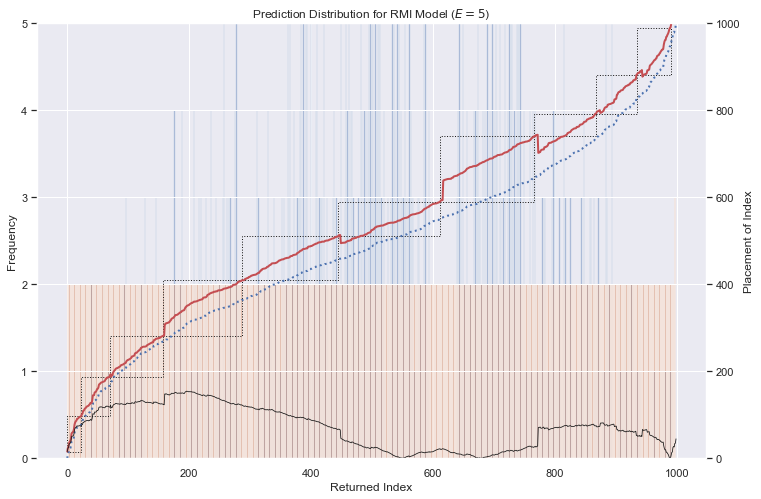

In [15]:
from matplotlib.patches import Rectangle
n_epochs=5
model = build_fit_rmi_model(dataset, stages=(1,10), n_neurons=32, n_epochs=n_epochs, verbose='auto', optimizer=keras.optimizers.Adam(learning_rate=5e-3), loss='mse', metrics=[MaxAbsoluteError()])
preds, lf = predict_rmi_model(model, testx, with_leaf=True)
lf, lfcounts = np.unique(lf, return_counts=True)
mkrs = [(0,0)]
for li in lfcounts:
    mkrs.append((mkrs[-1][1],mkrs[-1][1] + li - 1))
mkrs = mkrs[1:]
mkhts = [(preds[mi[0]], preds[mi[1]]) for mi in mkrs]
fig, ax = plt.subplots()
seps = np.arange(0, len(testx), 2)
linax = ax.twinx()
linax.set_ylabel("Placement of Index")
linax.set_ylim(0, len(testx))
gtruth = testx.flatten()
gtruth -= min(gtruth)
gtruth /= max(gtruth)
gtruth *= len(gtruth)
linax.plot(range(len(testx)), gtruth, linestyle='dotted', lw=2)
linax.plot(range(len(testx)), preds, lw=2, c='r')
linax.plot(range(len(testx)), abs(testy.reshape(-1)-preds.reshape(-1)), lw=0.8, c='k')
ax.hist(preds.reshape(-1), bins=seps, alpha=0.4, label='Predicted')
ax.hist(testy.reshape(-1), bins=seps, alpha=0.4, label='Actual')
ax.set_title(f"Prediction Distribution for RMI Model ($E={n_epochs}$)")
ax.set_xlabel("Returned Index")
ax.set_ylabel("Frequency")
ax.set_ylim(0,5)
# ax.vlines(mkrs, ymin=0, ymax=5, colors='k')
for m in range(len(mkrs)):
    linax.add_patch(Rectangle((mkrs[m][0], mkhts[m][0]), mkrs[m][1]-mkrs[m][0], mkhts[m][1] - mkhts[m][0], facecolor='none', edgecolor='k', linestyle='dotted'))
fig.set_size_inches((12,8))
plt.show()

In [5]:
cumloss = []
max_epoch = 50
for n_epochs in range(1,max_epoch+1):
    model = build_fit_rmi_model(dataset, n_neurons=128, n_epochs=n_epochs, optimizer=keras.optimizers.Adam(learning_rate=5e-3), loss='mse', verbose=0)

    preds = predict_rmi_model(model, testx)
    mse = keras.metrics.MeanSquaredError()
    mse.update_state(preds, testy.reshape(-1,1))
    cumloss.append(mse.result().numpy())
    
    c = np.c_[preds, testy.reshape(-1,1)]

    fig, (ax, lax) = plt.subplots(2,1)
    seps = np.arange(0, len(testx), 2)
    linax = ax.twinx()
    linax.set_ylabel("Placement of Index")
    linax.set_ylim(0, len(testx))
    linax.plot(range(len(testx)), range(len(testx)), linestyle='dotted', lw=2)
    linax.plot(range(len(testx)), preds, lw=2, c='r')
    ax.hist(preds.reshape(-1), bins=seps, alpha=0.4, label='Predicted')
    ax.hist(testy.reshape(-1), bins=seps, alpha=0.4, label='Actual')
    ax.set_title(f"Prediction Distribution for RMI Model ($E={n_epochs}$)")
    ax.set_xlabel("Returned Index")
    ax.set_ylabel("Frequency")
    ax.set_ylim(0,5)
    ax.legend(loc='upper left')
    lax.plot(range(len(cumloss)), np.log10(cumloss), c='k')
    lax.set_title("LogMSE Over Epochs")
    lax.set_xlabel("# Epoch")
    lax.set_ylabel("LogMSE")
    lax.set_xlim(0,max_epoch)
    lax.set_ylim(0,5)
    fig.set_size_inches((12,12))
    # plt.show()
    plt.tight_layout()
    plt.savefig(f"modeling_imgs/n_epochs_{n_epochs}.png")
    plt.close()
    print(f"{n_epochs}...", end=' ')

1... 2... 3... 4... 5... 6... 7... 8... 9... 10... 11... 12... 13... 14... 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\dsill\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-192a0f374722>", line 4, in <module>
    model = build_fit_rmi_model(dataset, n_neurons=128, n_epochs=n_epochs, optimizer=keras.optimizers.Adam(learning_rate=5e-3), loss='mse', verbose=0)
  File "C:\Users\dsill\Desktop\python-projects\CS490LDA-Project1\model.py", line 57, in build_fit_rmi_model
    nn.fit(tmp_records[i][j], epochs=n_epochs, verbose=verbose)#0)
  File "C:\Users\dsill\anaconda3\lib\site-packages\keras\engine\training.py", line 1184, in fit
    tmp_logs = self.train_function(iterator)
  File "C:\Users\dsill\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py", line 885, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\dsill\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py", line 917, in _call
    retu

TypeError: object of type 'NoneType' has no len()

In [ ]:
exm = new_stage_model(n_neurons=8, n_layers=1)
# exm.add_metric(keras.metrics.Sum(name='sum1')(exm.outputs), name='sum')
exm.compile(loss='mse', optimizer='adam', 
            metrics=[MaxAbsoluteError()])
exhist = exm.fit(dataset, epochs=100)
mape = exhist.history['max_absolute_error']
los = exhist.history['loss']
fig, (mapeax, lax, hax) = plt.subplots(3,1)
mapeax.plot(range(len(mape)), mape)
mapeax.set_title("MaxAE in training")
mapeax.set_xlabel("Epoch #")
mapeax.set_xticks(range(0,len(mape),5))
mapeax.set_ylabel("MaxAE")
lax.plot(range(len(mape)), los)
lax.set_title("MSE Loss in training")
lax.set_xlabel("Epoch #")
lax.set_xticks(range(0,len(mape),5))
lax.set_ylabel("MSE Loss")
lax.set_yscale('log')
preds = exm.predict(testx) + 1
seps = np.arange(0,L,max(1,L//25))
hax.hist(preds.reshape(-1), bins=seps, alpha=0.4, label='Predicted')
hax.hist(testy.reshape(-1), bins=seps, alpha=0.4, label='Actual')
hax.set_title("Key Distribution")
hax.set_xlim(0,L)
hax.set_ylim(0,L//2)
hax.set_xlabel("Key index")
hax.set_ylabel("Frequency")
hax.legend()
fig.set_size_inches((12,12))
plt.tight_layout()
plt.show()

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices()